# SEC Dataset Wrangling

- Goals of this notebook
- Put the SEC filing data in a "TIDY" format
    - 1 Row per company / submission?
    - 1 Row per company / Quarter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm

pd.set_option("display.max_columns", 500)
%load_ext lab_black

## Get a list of Companies to Test on

- Meta
- Exelon
- Amazon
- MSFT
- Pfizer
- Tesla
- Riot

In [3]:
numbers = pd.read_parquet("numbers.parquet")
subs = pd.read_parquet("parquets/submissions_combined.parquet")
subs["accepted"] = pd.to_datetime(subs["accepted"])

# Get all of Meta's Filings
- CIK number is unique to the company even though the name changed.
- CIK == 1326801

In [6]:
subs_meta = subs.query("cik == 1326801").reset_index(drop=True).copy()
num_ = numbers.merge(
    subs_meta[
        ["adsh", "period", "name", "cik", "filed", "accepted", "fy", "fp", "form"]
    ],
    validate="m:1",
).copy()
num_["period"] = pd.to_datetime(num_["period"], format="%Y%m%d")
num_["ddate"] = pd.to_datetime(num_["ddate"], format="%Y%m%d")
num_["name_latest"] = num_["cik"].map(num_.groupby("cik")["name"].last())

In [7]:
tags_to_keep = num_["tag"].value_counts().to_frame("count").query("count > 40").index

# Filter to:
- qtrs == 0

In [10]:
meta_unstacked = (
    num_.sort_values("accepted", ascending=False)
    .query("qtrs == 0")
    .groupby(["tag", "fy", "fp", "form", "name", "name_latest"])[
        ["value", "accepted", "filed", "ddate"]
    ]
    .first()
    .reset_index()
    .groupby(["name", "name_latest", "fy", "fp", "tag"])["value"]
    .first()
    .unstack()
    .reset_index()
)

meta_unstacked["quarter"] = meta_unstacked["fp"].replace("FY", "Q4")
meta_unstacked["fmonth"] = meta_unstacked["quarter"].str[-1].astype("int") * 3
meta_unstacked["fiscal_date"] = pd.to_datetime(
    meta_unstacked["fy"].astype("int").astype("str")
    + "-"
    + meta_unstacked["fmonth"].astype("str")
    + "-1"
)

Text(0.5, 1.0, 'Meta Assets Over Time')

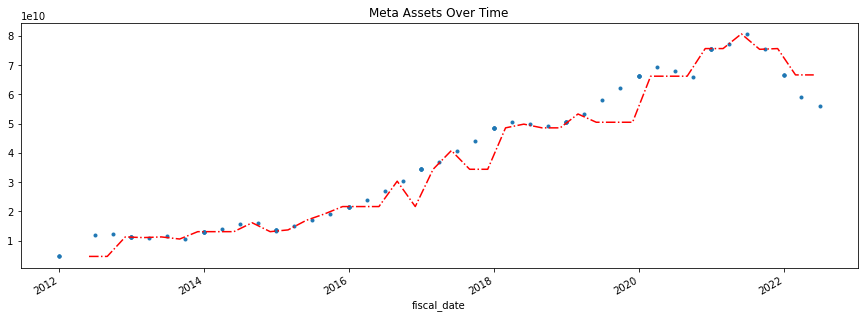

In [11]:
ax = (
    num_.sort_values("accepted", ascending=False)
    .query("qtrs == 0")
    .query('tag == "AssetsCurrent"')
    .set_index("ddate")["value"]
    .plot(figsize=(15, 5), style=".")
)


meta_unstacked.set_index("fiscal_date")["AssetsCurrent"].plot(
    ax=ax, color="red", style="-."
)

ax.set_title("Meta Assets Over Time")

In [12]:
meta_unstacked.loc[meta_unstacked["fiscal_date"].dt.year == 2017][
    ["AssetsCurrent", "fy", "fp"]
]

tag,AssetsCurrent,fy,fp
19,3.440100e+10,2017.0,FY
20,3.440100e+10,2017.0,Q1
21,4.080400e+10,2017.0,Q2
22,3.440100e+10,2017.0,Q3


In [21]:
(
    num_.sort_values("accepted", ascending=False)
    .query("qtrs == 0")
    .query('tag == "AssetsCurrent"')
    .query("fy == 2017")
)

,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote,filename,period,name,cik,filed,accepted,fy,fp,form,name_latest
7412,0001326801-18-000009,AssetsCurrent,us-gaap/2017,None,2016-12-31,0,USD,3.440100e+10,None,2018q1/num.txt,2017-12-31,FACEBOOK INC,1326801,20180201,2018-02-01 16:58:00,2017.0,FY,10-K,"META PLATFORMS, INC."
7413,0001326801-18-000009,AssetsCurrent,us-gaap/2017,None,2017-12-31,0,USD,4.856300e+10,None,2018q1/num.txt,2017-12-31,FACEBOOK INC,1326801,20180201,2018-02-01 16:58:00,2017.0,FY,10-K,"META PLATFORMS, INC."
6122,0001326801-17-000053,AssetsCurrent,us-gaap/2017,None,2016-12-31,0,USD,3.440100e+10,None,2017q4/num.txt,2017-09-30,FACEBOOK INC,1326801,20171102,2017-11-02 16:38:00,2017.0,Q3,10-Q,"META PLATFORMS, INC."
6123,0001326801-17-000053,AssetsCurrent,us-gaap/2017,None,2017-09-30,0,USD,4.420300e+10,None,2017q4/num.txt,2017-09-30,FACEBOOK INC,1326801,20171102,2017-11-02 16:38:00,2017.0,Q3,10-Q,"META PLATFORMS, INC."
6364,0001326801-17-000038,AssetsCurrent,us-gaap/2017,None,2017-06-30,0,USD,4.080400e+10,None,2017q3/num.txt,2017-06-30,FACEBOOK INC,1326801,20170727,2017-07-27 16:26:00,2017.0,Q2,10-Q,"META PLATFORMS, INC."
6363,0001326801-17-000038,AssetsCurrent,us-gaap/2017,None,2016-12-31,0,USD,3.440100e+10,None,2017q3/num.txt,2017-06-30,FACEBOOK INC,1326801,20170727,2017-07-27 16:26:00,2017.0,Q2,10-Q,"META PLATFORMS, INC."
5415,0001326801-17-000024,AssetsCurrent,us-gaap/2016,None,2016-12-31,0,USD,3.440100e+10,None,2017q2/num.txt,2017-03-31,FACEBOOK INC,1326801,20170504,2017-05-04 16:21:00,2017.0,Q1,10-Q,"META PLATFORMS, INC."
5416,0001326801-17-000024,AssetsCurrent,us-gaap/2016,None,2017-03-31,0,USD,3.693000e+10,None,2017q2/num.txt,2017-03-31,FACEBOOK INC,1326801,20170504,2017-05-04 16:21:00,2017.0,Q1,10-Q,"META PLATFORMS, INC."


# Unstack Everything?

In [ ]:
num_ = numbers.merge(
    subs[
        ["adsh", "period", "name", "cik", "filed", "accepted", "fy", "fp", "form"]
    ],
    validate="m:1",
).copy()
num_["period"] = pd.to_datetime(num_["period"], format="%Y%m%d")
num_["ddate"] = pd.to_datetime(num_["ddate"], format="%Y%m%d")
num_["name_latest"] = num_["cik"].map(num_.groupby("cik")["name"].last())